In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import plot_accumulated,find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

In [2]:
mode = 'validation'
real = np.load('/user/home/al18709/work/cgan_predictions/%s_real-opt.npy' % mode)[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/cgan_predictions/%s_pred-opt.npy' % mode)[0][:,:,:,0]
inputs = np.load('/user/home/al18709/work/cgan_predictions/%s_input-opt.npy' % mode)[0][:,:,:,0]
meta = pd.read_csv('/user/work/al18709/tc_data_mswep/valid_meta.csv')
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [3]:
print(real.shape)
print(meta.shape)

(3193, 100, 100)
(3098, 5)


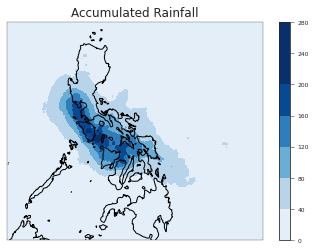

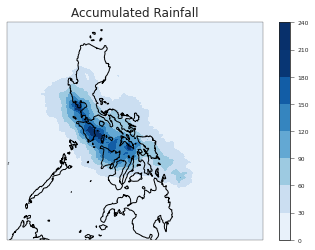

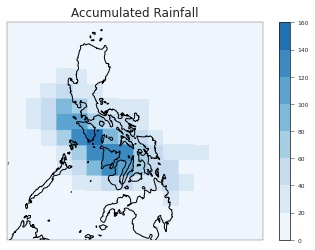

<xarray.Dataset>
Dimensions:        ()
Data variables:
    precipitation  float64 92.72


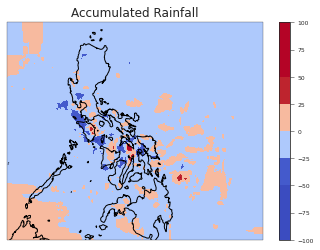

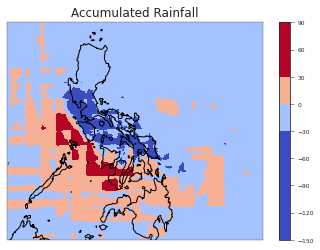

ValuesView(<xarray.Dataset>
Dimensions:        ()
Data variables:
    precipitation  float64 10.35)
ValuesView(<xarray.Dataset>
Dimensions:        ()
Data variables:
    precipitation  float64 18.17)
<xarray.Dataset>
Dimensions:        ()
Data variables:
    precipitation  float64 88.57


In [21]:
# get list of landfalling tcs
landfall_sids = find_landfalling_tcs(meta)

# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in landfall_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# grab mswep coordinate variables
fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon		

# clip to entire TC region
lats,lons = tc_region(meta,sid_2008169N08135,lat,lon)

# initialise accumulated xarray
grid_x, grid_y = np.meshgrid(lats, lons)
a = np.zeros((grid_x.shape))
accumulated_ds = create_xarray(lats,lons,a)
accumulated_ds_pred = create_xarray(lats,lons,a)
accumulated_ds_input = create_xarray(lats,lons,a)


# accumulated = np.zeros(grid_x.shape)
for i in sid_2008169N08135:
	storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
	ds = create_xarray(storm_lats,storm_lons,real[i])
	ds_pred = create_xarray(storm_lats,storm_lons,pred[i])
	input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
	ds_input = create_xarray(input_lats,input_lons,inputs[i])

	# regrid so grids match
	regridder = xe.Regridder(ds, accumulated_ds, "nearest_s2d")
	ds_out = regridder(ds)
	ds_pred_out = regridder(ds_pred)

	# regird the inputs
	# regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
	regridder = xe.Regridder(ds_input, accumulated_ds, "nearest_s2d")
	ds_input_out = regridder(ds_input)

	# add up rainfall
	accumulated_ds = accumulated_ds + ds_out
	accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
	accumulated_ds_input = accumulated_ds_input + ds_input_out

# hr_ds = create_xarray(storm_lats,storm_lons,real[i])

# plot accumulated rainfall
# https://earthobservatory.nasa.gov/images/8868/rainfall-from-typhoon-fengshen
plot_accumulated(accumulated_ds['precipitation'],accumulated_ds['lat'].values,accumulated_ds['lon'].values,plot='show')
plot_accumulated(accumulated_ds_pred['precipitation'],accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,plot='show')
plot_accumulated(accumulated_ds_input['precipitation'],accumulated_ds_input['lat'].values,accumulated_ds_input['lon'].values,plot='show')

# real_accumulated = accumulated_ds

anomaly = accumulated_ds_pred - accumulated_ds
rmse_hr = np.sqrt(((accumulated_ds_pred - accumulated_ds) ** 2).mean()).values()
print(anomaly.max())
plot_accumulated(anomaly['precipitation'],anomaly['lat'].values,anomaly['lon'].values,plot='show',vmin=-40,vmax=40,cmap='coolwarm')

anomaly_lr = accumulated_ds_input - accumulated_ds
plot_accumulated(anomaly_lr['precipitation'],anomaly_lr['lat'].values,anomaly_lr['lon'].values,plot='show',vmin=-40,vmax=40,cmap='coolwarm')
rmse_lr = np.sqrt(((accumulated_ds_input - accumulated_ds) ** 2).mean()).values()
print(rmse_hr)
print(rmse_lr)
print(anomaly_lr.max())
